In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
import spacy
nlp = spacy.load('ru_core_news_sm')

from tqdm import tqdm

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dasha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Загрузка датасета

In [2]:
df=pd.read_csv(r'D:\Python_Projects\hakaton\dataset\emotional_dataset.csv')

In [3]:
df.head()

,text,target
0,"Да, все-таки он немного похож на него. Но мой мальчик все равно лучше:D",1
1,RT @KatiaCheh: Ну ты идиотка) я испугалась за тебя!!!,1
2,"RT @digger2912: ""Кто то в углу сидит и погибает от голода, а мы ещё 2 порции взяли, хотя уже и так жрать не хотим"" :DD http://t.co/GqG6iuE2…",1
3,"@irina_dyshkant Вот что значит страшилка :D\nНо блин,посмотрев все части,у тебя создастся ощущение,что авторы курили что-то :D",1
4,ну любишь или нет? — Я не знаю кто ты бля:D http://t.co/brf9eNg1U6,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430517 entries, 0 to 430516
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    430517 non-null  object
 1   target  430517 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.6+ MB


<Axes: ylabel='target'>

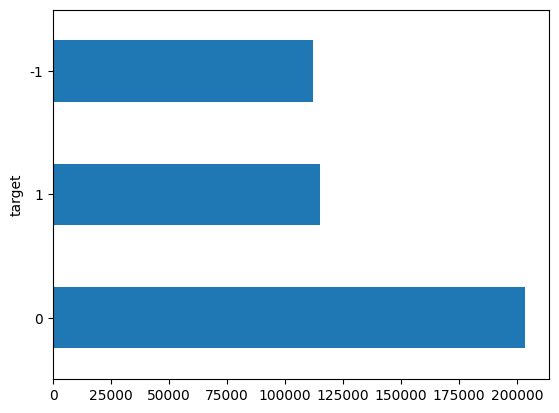

In [5]:
df['target'].value_counts().plot.barh()

В датасете сохранены комментарии с негативной и позитивной окраской примерно по 110 тысяч и в 2 раза больше нейтральных комментариев.

Датасет собран из двух: 
+ https://www.kaggle.com/datasets/alexandersemiletov/toxic-russian-comments
+ https://www.kaggle.com/datasets/thorinhood/russian-twitter-sentiment

### Преобработка

+ приводим к нижнему регистру

In [6]:
df['prepared_text'] = df['text'].str.lower()

+ убираем слово RT

In [7]:
df['prepared_text'] = df['prepared_text'].apply(lambda x: x.replace('rt ',''))

+ слова с @

In [8]:
df['prepared_text'] = df['prepared_text'].apply(lambda x: ' '.join([word for word in x.split() if not word.startswith('@')]))

Выбираем из текста только смайлики :) :( ;) :0

In [9]:
def smiles_text(text):
    valid_parts = re.findall(r'(:\)|:\(|:d|:0|xd|;\))', text)
    cleaned_text = ' '.join(valid_parts).strip()
    return cleaned_text

Выбираем только русские буквы и убираем лишние пробелы

In [10]:
def russian_text(text):
    cleaned_text = re.sub(r'[^а-яё ]', ' ', text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    return cleaned_text

Выбираем только скобочки ) )) ))) )))) ( (( ((( ((((

In [11]:
def keep_parentheses(text):
    matches = re.findall(r'\s*\(\s*|\s*\)\s*', text)
    cleaned_text = ' '.join(matches).strip()
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    return cleaned_text

Отделяем скобочки от слов "привет))" -> "привет ) )"

In [12]:
def modify_text(text):
    text = re.sub(r'\)+', lambda m: ' ' + ')' * len(m.group(0)), text)
    text = re.sub(r'\(+', lambda m: ' ' + '(' * len(m.group(0)), text)
    return text

Применяем все выше перечисленное к датасету и соединяем вместе

In [13]:
df['separate'] = df['prepared_text'].apply(modify_text)
df['smiles'] = df['prepared_text'].apply(smiles_text)
df['russian'] = df['prepared_text'].apply(russian_text)
df['scobs'] = df['separate'].apply(keep_parentheses)
df['prepared_text'] = df['russian']+' '+df['smiles']+' '+df['scobs'] 

df = df.drop(['separate','russian','smiles','scobs'],axis=1)

Преобразуем смайлики из нижнего регистра в высокий

In [14]:
df['prepared_text']=df['prepared_text'].str.replace(':d',':D')
df['prepared_text']=df['prepared_text'].str.replace('xd','XD')

In [15]:
df.head()

,text,target,prepared_text
0,"Да, все-таки он немного похож на него. Но мой мальчик все равно лучше:D",1,да все таки он немного похож на него но мой мальчик все равно лучше :D
1,RT @KatiaCheh: Ну ты идиотка) я испугалась за тебя!!!,1,ну ты идиотка я испугалась за тебя )
2,"RT @digger2912: ""Кто то в углу сидит и погибает от голода, а мы ещё 2 порции взяли, хотя уже и так жрать не хотим"" :DD http://t.co/GqG6iuE2…",1,кто то в углу сидит и погибает от голода а мы ещё порции взяли хотя уже и так жрать не хотим :D
3,"@irina_dyshkant Вот что значит страшилка :D\nНо блин,посмотрев все части,у тебя создастся ощущение,что авторы курили что-то :D",1,вот что значит страшилка но блин посмотрев все части у тебя создастся ощущение что авторы курили что то :D :D
4,ну любишь или нет? — Я не знаю кто ты бля:D http://t.co/brf9eNg1U6,1,ну любишь или нет я не знаю кто ты бля :D


### Подготовка к обучению

удаление дубликатов

In [16]:
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)

9397


Функция для лемматизации

In [17]:
results = []

def preprocess_text(text):
    doc = nlp(text)
    lemma_tokens = [token.lemma_ for token in doc]
    return " ".join(lemma_tokens)

Применение лемматизации

In [18]:
for text in tqdm(df['prepared_text'], desc="Processing texts"):
    result = preprocess_text(text)
    results.append(result)

Processing texts: 100%|██████████| 421120/421120 [1:22:46<00:00, 84.80it/s] 


In [19]:
df['prepared_text_lemm'] = results

Удаление стоп-слов

In [20]:
stop = stopwords.words('russian')
df["prepared_text_lemm_nostop"] = df['prepared_text_lemm'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [21]:
df.head()

,text,target,prepared_text,prepared_text_lemm,prepared_text_lemm_nostop
0,"Да, все-таки он немного похож на него. Но мой мальчик все равно лучше:D",1,да все таки он немного похож на него но мой мальчик все равно лучше :D,да все таки он немного похожий на него но мой мальчик все равный хороший :d,таки немного похожий мальчик равный хороший :d
1,RT @KatiaCheh: Ну ты идиотка) я испугалась за тебя!!!,1,ну ты идиотка я испугалась за тебя ),ну ты идиотка я испугаться за тебя ),идиотка испугаться )
2,"RT @digger2912: ""Кто то в углу сидит и погибает от голода, а мы ещё 2 порции взяли, хотя уже и так жрать не хотим"" :DD http://t.co/GqG6iuE2…",1,кто то в углу сидит и погибает от голода а мы ещё порции взяли хотя уже и так жрать не хотим :D,кто то в угол сидеть и погибать от голод а мы ещё порция взять хотя уже и так жрать не хотеть :d,угол сидеть погибать голод ещё порция взять хотя жрать хотеть :d
3,"@irina_dyshkant Вот что значит страшилка :D\nНо блин,посмотрев все части,у тебя создастся ощущение,что авторы курили что-то :D",1,вот что значит страшилка но блин посмотрев все части у тебя создастся ощущение что авторы курили что то :D :D,вот что значить страшилка но блин посмотреть весь часть у тебя создаться ощущение что автор курить что то :d :d,значить страшилка блин посмотреть весь часть создаться ощущение автор курить :d :d
4,ну любишь или нет? — Я не знаю кто ты бля:D http://t.co/brf9eNg1U6,1,ну любишь или нет я не знаю кто ты бля :D,ну любить или нет я не знать кто ты бля :d,любить знать бля :d


In [22]:
df.to_csv(r'D:\Python_Projects\hakaton\dataset\emotional_dataset_full.csv')